Let's consider the problem of fitting some data points to a straight line model
\begin{equation}
y = m x + b
\end{equation}
Using Python, we have SO MANY ways of doing this fit and getting errors on the derived slope and intercept. 

0) Since this is a linear model, we have the analytical formula using matrix operations.  Here we calculate the covariance matrix ourselves.

1) `numpy.polyfit`.  Again, to get the covariance we expect we have to use a keyword: `cov='unscaled'`

2) `scipy.optimize.curve_fit`.  `curve_fit` will return a covariance, but to get the one we think we should get, we need to tell it `absolute_sigma=True`.

3) `astropy.modeling`.  To get `astropy` to return a covariance matrix for the parameters, we need to use `fitting.LevMarLSQFitter` (Levenberg-Marquardt least-squares algorithm) and not `fitting.LinearLSQFitter`.  

They all give the same answer, and the same (analytical) covariance.  Let's see if we can get this covariance from the data.  We can use any method with multiple simulations to derive a covariance from the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats
from scipy.optimize import curve_fit

In [2]:
# define a model for a line (uses astropy models, but not the fitting functions)
line_orig = models.Linear1D(slope=1.0, intercept=0.0)

# generate x, y data non-uniformly spaced in x
# add noise to y measurements
npts = 30
#np.random.seed(10)
x = np.random.uniform(0.0, 10.0, npts)
y = line_orig(x)
yunc = np.random.normal(0.0, 0.5, npts)
y += yunc

Below we're going to define a linear fit according to the linear least squares mathematics, with the weight matrix $W$ assumed to be the identity (`np.eye`, get it?) if none is provided.  Note that `np.matmul` is matrix multiplication in the usual way, so
\begin{equation}
X^T W X
\end{equation}
for example, is written as `np.matmul(X.T, np.matmul(W, X))`.  That is, first multiply $W X$ (order matters!) and then multiply $X^T$ on that product.

In [3]:
def LinearFit(x, y, W = None):
    
    if W is None:
        W = np.eye(len(x))
        
    # Make the matrix X.  
    # A constant vector, and a vector proportional to the independent variable x
    X = np.array([[np.ones_like(x)], [x]]).squeeze().T
    Cinv = np.matmul(X.T, np.matmul(W, X))
    C = np.linalg.inv(Cinv)
    params = np.matmul(C, np.matmul(X.T, np.matmul(W, y)))
    return params, C

In [4]:
params, C = LinearFit(x, y)
print('Parameters')
print(params)
print('Covariance')
print(C)

Parameters
[-0.01888724  1.01067964]
Covariance
[[ 0.14807692 -0.02457968]
 [-0.02457968  0.00526531]]


In [5]:
# Polyfit
p, cov = np.polyfit(x, y, 1, cov='unscaled')
print('Parameters')
print(p)
print('Covariance')
print(cov)

Parameters
[ 1.01067964 -0.01888724]
Covariance
[[ 0.00526531 -0.02457968]
 [-0.02457968  0.14807692]]


In [6]:
def Line(x, m, b):
    return m * x + b

params, params_covariance = curve_fit(Line, x, y, p0=[1, 0], absolute_sigma=True)
print('Parameters')
print(params)
print('Covariance')
print(params_covariance)

Parameters
[ 1.01067964 -0.01888723]
Covariance
[[ 0.00526533 -0.02457976]
 [-0.02457976  0.14807711]]


The tutorial page for using the `astropy` fitting functions:

https://docs.astropy.org/en/stable/modeling/example-fitting-line.html

In [7]:
# Use astropy
# Initialize a linear fitter
fit = fitting.LinearLSQFitter()
# initialize a linear model
line_init = models.Linear1D()
# Initialize the truth
line_orig = models.Linear1D(slope=1.0, intercept=0.0)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept      
    ----------------- ---------------------
    1.010679642241815 -0.018887235628364432
[[ 0.00115777 -0.00540473]
 [-0.00540473  0.03256007]]


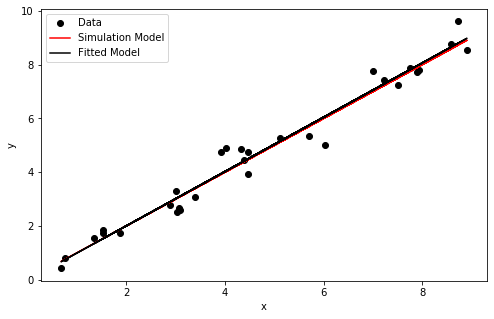

In [8]:
# The astropy method
# initialize a linear fitter
#fit = fitting.LinearLSQFitter() # for some reason, this does not compute a covariance matrix
fit = fitting.LevMarLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, x, y)

print(fitted_line)
print(fit.fit_info['param_cov'])

# plot
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko', label='Data')
plt.plot(x, line_orig(x), 'r-', label='Simulation Model')
plt.plot(x, fitted_line(x), 'k-', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [9]:
%%time
# Create many realizations of the noise.
Nrlz = 10000
npts = 30
sigma = 1.0
# We have 
slopes = np.zeros(Nrlz) 
intercepts = np.zeros(Nrlz)
covariances = np.zeros([Nrlz,2,2])
for i in np.arange(Nrlz):
    # Generate the random x, y positions, values and errors
    x = np.random.uniform(0.0, 10.0, npts)
    y = line_orig(x) + np.random.normal(0.0, sigma, npts)
    
    # fit the data with the astropy fitter ... they're all the same
    fitted_line = fit(line_init, x, y)
    # save the result
    slopes[i] = fitted_line.slope.value
    intercepts[i] = fitted_line.intercept.value
    covariances[i,:,:] = fit.fit_info['param_cov']
    
empirical_covariance = np.cov((np.array([[slopes], [intercepts]])).squeeze())

CPU times: user 25.6 s, sys: 343 ms, total: 25.9 s
Wall time: 26.6 s


In [10]:
analytic_covariance = covariances.mean(axis=0)

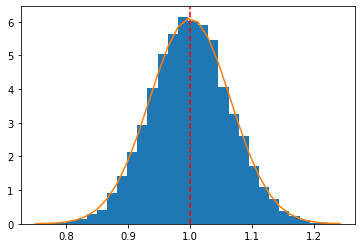

In [11]:
m_hist, m_bins, patches = plt.hist(slopes, bins=30, density=True)
plt.axvline(1.0, color='red', linestyle='--')
plt.plot(m_bins, stats.norm.pdf(m_bins, loc=1., scale=np.sqrt(analytic_covariance[0,0])))
plt.show()

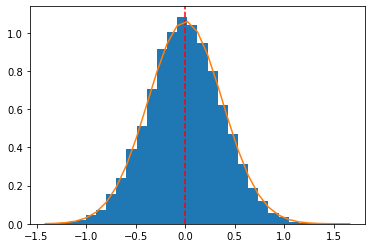

In [12]:
b_hist, b_bins, patches = plt.hist(intercepts, bins=30, density=True)
plt.axvline(0.0, color='red', linestyle='--')
plt.plot(b_bins, stats.norm.pdf(b_bins, loc=0., scale=np.sqrt(analytic_covariance[1,1])))
plt.show()

In [13]:
print('Empirical Covariance')
print(empirical_covariance)
print('Average of Analytic Covariance')
print(analytic_covariance)

Empirical Covariance
[[ 0.00415745 -0.02092647]
 [-0.02092647  0.13871796]]
Average of Analytic Covariance
[[ 0.00427013 -0.02135882]
 [-0.02135882  0.1413931 ]]
